# Dataset Generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
t_ref         = 298         #K          Reference temperature
delta_S0      = -162.86     #J/mol.K    Standard Entropy change
n             = 2           #           Number of electrons
F             = 96485       #C/mol      Faraday constant
R             = 8.315       #J/mol.K    Universal Gas Constant
delta_H0      = -286.02     #Kj/mol     Standard Enthalpy change
wt_percent    = 30          #%          Weight percent of KOH solution
gamma_a       = 1.25        #           Electrode Roughness Factor Anode
gamma_c       = 1.05        #           Electrode Roughness Factor Cathode
deltaG_a      = 41500       #J/mol.K    Free Energy of Activation Anode
deltaG_c      = 23450       #J/mol.K    Free Energy of Activation Cathode
i_o_ref_a     = 1.34535e-5  #A/cm2      Reference Exchange Current Density Anode
i_o_ref_c     = 1.8456e-3   #A/cm2      Reference Exchange Current Density Cathode
A_a           = 10000 #DESIGN VARIABLE      #cm2        Surface Area of Anode
A_c           = A_a         #cm2        Surface Area of Cathode
A_m           = 0.9*A_a     #cm2        Surface Area of Membrane
t_a           = 0.2         #cm         Thickness of Anode Electrode
t_c           = 0.2         #cm         Thickness of Cathode Electrode
t_m           = 0.05        #cm         Thickness of Membrane
rho_a         = 6.4e-6      #ohmcm      Resistivity of the 100%-Dense NI Electrode 
rho_c         = 6.4e-6      #ohmcm      Resistivity of the 100%-Dense NI Electrode 
k_a           = 0.00586     #/Celcius   Temperature Coefficient of Resistivity
k_c           = 0.00586     #/Celcius   Temperature Coefficient of Resistivity
d_am          = 0.125       #cm         Distance Between Anode and Membrane
d_cm          = 0.125       #cm         Distance Between Cathode and Membrane
eps_a         = 0.3         #           Porosity of Anode
eps_c         = 0.3         #           Porosity of Cathode
eps_m         = 0.42        #           Porosity of Membrane
tau_m         = 2.18        #           Tortuosity of Membrane
w_m           = 0.85        #           Separator Wettability Factor
j_lim         = 30          #A/cm2      Limiting current Density at 100 % bubble coverage 
N             = 1600  #DESIGN VARIABLE

U_tn = 1.48
erev = 1.229

In [3]:
T             = 273+75         #K
P             = 7           #bar
i             = 0.3  #DESIGN VARIABLE    #A/cm2

In [4]:
# Function to calculate the bubble coverage
def calculate_bubble_coverage(i,T,P,):
    #Vapor pressure of pure H2O
    term1 = np.log (T)
    #print("term1: ",term1)
    term2 = 37.043 - (6275.7 / T) - 3.4159*term1
    #print("term2: ",term2)
    p0_H2O = np.exp (term2)
    #p0_H2O = (T**-3.4159)*np.exp(37.043 - (6275.7/T))
    #print("p0_H2O: ",p0_H2O)
    term3 = np.exp (wt_percent / 115.96277)
    #print("term3: ",term3)
    m = (wt_percent * (183.1221 - (0.56845 * T) + (984.5679 * term3))) / 5610.5
    #print("m: ",m)
    #Vapor pressure of H2O
    term4 = 0.016214 - (0.13802 * m) + (0.19330 * m**0.5) + (1.0239 * np.log (p0_H2O))
    #print("term4: ",term4)
    pH2O = np.exp (term4)
    #print("pH2O: ",pH2O)
    #pH2O = (T**-3.498)*np.exp(37.93 - (6426.32/T))*np.exp(0.016214 - (0.13802 * m) + (0.19330 * m**0.5))

    #theta is the fractional bubble coverage. j_lim is the limiting current density at 100% bubble coverage.
    theta = (-97.25 + 182 * (T / t_ref) - 84 * (T / t_ref)**2) * ((i / j_lim)**0.3) * (P / (P - pH2O))

    #print (theta)
    return theta
    

In [5]:
# Function to calculate reversible voltage
def calculate_reversible_voltage(T,P):
    #Vapor pressure of pure H2O
    term1 = np.log (T)
    term2 = 37.043 - (6275.7 / T) - 3.4159*term1
    p0_H2O = np.exp (term2)
    #p0_H2O = (T**-3.4159)*np.exp(37.043 - (6275.7/T))
    
    term3 = np.exp (wt_percent / 115.96277)
    m = (wt_percent * (183.1221 - (0.56845 * T) + (984.5679 * term3))) / 5610.5
    
    #Vapor pressure of H2O
    term4 = 0.016214 - (0.13802 * m) + (0.19330 * m**0.5) + (1.0239 * np.log (p0_H2O))
    pH2O = np.exp (term4)
    #pH2O = (T**-3.498)*np.exp(37.93 - (6426.32/T))*np.exp(0.016214 - (0.13802 * m) + (0.19330 * m**0.5))
    
    erev = 1.229
    
    term5 = ((P - pH2O)**1.5) * p0_H2O/ pH2O
    V_rev = erev + ((T - t_ref)*(-0.9e-3)) + (((R * T) / (2 * F)) * np.log(term5))
    
    return V_rev

In [6]:
# Function to calculate activation overpotential
def calculate_activation_overpotential(i,T,P):
    


    #alpha_a,c is the charge transfer co-efficient of anode and cathode
    alpha_a = 0.0675 + 0.00095 * T
    alpha_c = 0.1175 + 0.00095 * T
    

    #b_a,c is the "Tafel Slope". The slope of activation overpotential in linear region of polarization curve is determined by tafel slope
    b_a = (R * T) / (n * F * alpha_a)
    b_c = (R * T) / (n * F * alpha_c)
    
    #i_o_a,c is the exchange current density. gamma_a,c is the reference exchange current density at Reference Temperature.
    i_o_a = gamma_a * i_o_ref_a * np.exp((-deltaG_a / R) * ((1 / T) - (1 / t_ref)))
    i_o_c = gamma_c * i_o_ref_c * np.exp((-deltaG_c / R) * ((1 / T) - (1 / t_ref)))


    theta=calculate_bubble_coverage(i,T,P)    
    
    
    #Activation Overpotential
    V_act_anode = b_a * np.log (i / i_o_a) + b_a * np.log(1 / (1 - theta))
    V_act_cathode = b_c * np.log (i / i_o_c) + b_c * np.log(1 / (1 - theta))
    
    V_act = V_act_anode + V_act_cathode
    return V_act

In [7]:
# Function to calculate ohmic overpotential
def calculate_ohmic_overpotential(i,T,P): 
    
    theta=calculate_bubble_coverage(i,T,P)

    term3 = np.exp (wt_percent / 115.96277)
    m = (wt_percent * (183.1221 - (0.56845 * T) + (984.5679 * term3))) / 5610.5
    
    #Effective Resistivity of anode and cathode. eps_a,c is the resistivity of 100% dense cathode,anode an Reference Temperature.
    rho_eff_a = rho_a / ((1 - eps_a)**1.5)
    rho_eff_c = rho_c / ((1 - eps_c)**1.5)
    
    #Electrode Resistance
    R_ele = ((rho_eff_a * t_a / A_a) * (1 + k_a * (T - t_ref))) + ((rho_eff_c * t_c / A_c) * (1 + k_c * (T - t_ref)))
    
    #sigma_KOH_free is the tortuosity of memebrane
    sigma_KOH_free = (-2.04 * m) - (0.0028 * m**2) + (0.005332 * m * T) + (207.2 * m / T) + (0.001043 * m**3) - (0.0000003 * m**2 * T**2)
    
    #Bubble Free electrolyte resistance
    R_ely_free = (1 / sigma_KOH_free) * ((d_am / A_a) + (d_cm / A_c))
    
    #Electrolyte Resistance with bubbles
    R_ely_bubble = R_ely_free * ((1 / (1 - ((2/3)*theta))**1.5)-1)
    
    #Electrolyte Resistance = Sum of electrolytic resistance with and without bubble formation
    R_ely = R_ely_free + R_ely_bubble
    
    #Memebrane Resistance
    R_mem = (1 / sigma_KOH_free) * ((tau_m**2 * t_m) / (w_m * eps_m * A_m))
    
    I = i * (A_a)
    
    V_ohmic = I * (R_ele + R_ely + R_mem)
    return V_ohmic


In [8]:
# Function to calculate cell voltage
def calculate_cell_voltage(i,T,P):
    V_rev = calculate_reversible_voltage(T,P)
    V_act = calculate_activation_overpotential(i,T,P)
    V_ohmic = calculate_ohmic_overpotential(i,T,P)
    
    V_cell = (V_rev+ V_act+ V_ohmic)
    
    return V_cell

In [9]:
# Function to calculate hydrogen evolution rate
def calculate_hydrogen_evolution_rate(i):
    # Define hydrogen evolution rate calculation here
    return i * A_c * N / (2 * F)  # Rate of hydrogen evolution (mol/sec)

In [10]:
# Function to calculate oxygen evolution rate
def calculate_oxygen_evolution_rate(i):
    # Define oxygen evolution rate calculation here
    return i * A_a * N / (4 * F)  # Rate of oxygen evolution (mol/sec)

In [11]:
# Current density range
current_density_range = np.linspace(0, 0.5, 100)[1:]  # A/cm^2

In [12]:
# Temperature range
temperature_range = [273+30, 273+40, 273 + 50, 273 + 60, 273 + 70, 273 + 80, 273 + 90, 273 + 100]  # K

In [13]:
# Accumulate cell voltage for different temperatures
cell_voltage_all_temps = []
for T in temperature_range:
    cell_voltage = [calculate_cell_voltage(i,T,P) for i in current_density_range]
    cell_voltage_all_temps.append(cell_voltage)

In [14]:
# Accumulate bubble coverage for different temperatures
bubble_coverage_all_temps = []
for T in temperature_range:
    bubble_coverage = [calculate_bubble_coverage(i,T,P) for i in current_density_range]
    bubble_coverage_all_temps.append(bubble_coverage)

In [15]:
# Pressure range
pressure_range = [2, 4, 6, 8, 10]  # bar

In [16]:
# Accumulate cell voltage for different temperatures
cell_voltage_all_pressures = []
for P in pressure_range:
    cell_voltage = [calculate_cell_voltage(i,T,P) for i in current_density_range]
    cell_voltage_all_pressures.append(cell_voltage)

In [17]:
# Calculate cell voltage for different current densities
V_reversible = calculate_reversible_voltage(T,P)
activation_overpotential = [calculate_activation_overpotential(i,T,P) for i in current_density_range]
ohmic_overpotential = [calculate_ohmic_overpotential(i,T,P) for i in current_density_range]
cell_voltage = [calculate_cell_voltage(i,T,P) for i in current_density_range]
hydrogen_prod_rate = [calculate_hydrogen_evolution_rate(i) for i in current_density_range]

Total_hydrogen_production = [calculate_hydrogen_evolution_rate(i) for i in current_density_range * 86400 * 2 / 1000]

Faraday_efficiency =  [calculate_hydrogen_evolution_rate(i) * 2 * F / (N * i * A_c) for i in current_density_range] 

Energy_efficiency =  [U_tn / calculate_cell_voltage(i,T,P) for i in current_density_range]

In [18]:
len(Total_hydrogen_production)

99

In [19]:
current_density_range = np.linspace(0, 0.5, 100)[1:] 
temperature_range = [273+30, 273+40, 273 + 50, 273 + 60, 273 + 70, 273 + 80, 273 + 90, 273 + 100]  # K
pressure_range = [2, 4, 6, 8, 10]

In [20]:
data=[]
for T in temperature_range:
    for P in pressure_range:
        for i in current_density_range:
            data.append([T,P,i])

In [21]:
df=pd.DataFrame(data,columns=["Temperature","Pressure","Current Density"])

In [22]:
display(df)

,Temperature,Pressure,Current Density
0,303,2,0.005051
1,303,2,0.010101
2,303,2,0.015152
3,303,2,0.020202
4,303,2,0.025253
...,...,...,...
3955,373,10,0.479798
3956,373,10,0.484848
3957,373,10,0.489899
3958,373,10,0.494949


In [23]:
bubble_coverage_list=[]
reversible_voltage_list=[]
activation_overpotential_list=[]
ohmic_overpotential_list=[]
cell_voltage_list=[]
hydrogen_evolution_rate_list=[]
oxygen_evolution_rate_list=[]

In [24]:
for k in range (len(df)):
    current_density = df["Current Density"][k]
    temperature = df["Temperature"][k]
    pressure = df["Pressure"][k]
    
    bubble_coverage = calculate_bubble_coverage(current_density,temperature,pressure)
    bubble_coverage_list.append(bubble_coverage)
    
    reversible_voltage = calculate_reversible_voltage(temperature,pressure)
    reversible_voltage_list.append(reversible_voltage)
    
    activation_overpotential = calculate_activation_overpotential(current_density,temperature,pressure)
    activation_overpotential_list.append(activation_overpotential)
    
    ohmic_overpotential = calculate_ohmic_overpotential(current_density,temperature,pressure)
    ohmic_overpotential_list.append(ohmic_overpotential)
    
    cell_voltage = calculate_cell_voltage(current_density,temperature,pressure)
    cell_voltage_list.append(cell_voltage)
    
    hydrogen_evolution_rate = calculate_hydrogen_evolution_rate(current_density)
    hydrogen_evolution_rate_list.append(hydrogen_evolution_rate)

    oxygen_evolution_rate = calculate_oxygen_evolution_rate(current_density)
    oxygen_evolution_rate_list.append(oxygen_evolution_rate)

In [25]:
df["Bubble Coverage"]=bubble_coverage_list

In [26]:
df["Reversible Voltage"]=reversible_voltage_list
df["Activation Overpotential"]=activation_overpotential_list
df["Ohmic Potential"]=ohmic_overpotential_list
df["Cell Voltage"]=cell_voltage_list
df["Hydrogen Evolution Rate"]=hydrogen_evolution_rate_list
df["Oxygen Evolution Rate"]=oxygen_evolution_rate_list

In [27]:
df

,Temperature,Pressure,Current Density,Bubble Coverage,Reversible Voltage,Activation Overpotential,Ohmic Potential,Cell Voltage,Hydrogen Evolution Rate,Oxygen Evolution Rate
0,303,2,0.005051,0.071807,1.244385,0.230413,0.007401,1.482199,0.418760,0.209380
1,303,2,0.010101,0.088405,1.244385,0.279450,0.014873,1.538708,0.837520,0.418760
2,303,2,0.015152,0.099839,1.244385,0.308278,0.022383,1.575046,1.256279,0.628140
3,303,2,0.020202,0.108839,1.244385,0.328807,0.029923,1.603115,1.675039,0.837520
4,303,2,0.025253,0.116374,1.244385,0.344778,0.037488,1.626651,2.093799,1.046900
...,...,...,...,...,...,...,...,...,...,...
3955,373,10,0.479798,-0.324272,1.221870,0.365210,0.262631,1.849712,39.782182,19.891091
3956,373,10,0.484848,-0.325292,1.221870,0.365910,0.265351,1.853132,40.200942,20.100471
3957,373,10,0.489899,-0.326305,1.221870,0.366603,0.268070,1.856544,40.619702,20.309851
3958,373,10,0.494949,-0.327310,1.221870,0.367289,0.270789,1.859948,41.038462,20.519231


In [28]:
df = df.sample(frac = 1).reset_index(drop=True)

In [29]:
df.columns

Index(['Temperature', 'Pressure', 'Current Density', 'Bubble Coverage',
       'Reversible Voltage', 'Activation Overpotential', 'Ohmic Potential',
       'Cell Voltage', 'Hydrogen Evolution Rate', 'Oxygen Evolution Rate'],
      dtype='object')

# AutoEncoders

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np

In [31]:
# Define custom Dataset
class BubbleCoverageDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return x, y

In [32]:
class Attention(nn.Module):
    def __init__(self, input_dim):
        super(Attention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.Tanh(),
            nn.Linear(input_dim, 1),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        attention_weights = self.attention(x)
        weighted_output = x * attention_weights
        return weighted_output

In [33]:
# Define Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Output is a single value for Bubble Coverage
        )
        self.attention = Attention(encoding_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        attended = self.attention(encoded)
        encoded_with_residual = encoded + attended
        decoded = self.decoder(encoded_with_residual)
        #decoded = self.decoder(encoded)
        return decoded

In [34]:
def train_autoencoder(df, epochs=100, batch_size=32, learning_rate=0.001, encoding_dim=32, weight_decay=0.0):
    # Check for GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Split dataset into train and test
    features = df[['Temperature', 'Pressure', 'Current Density', 'Bubble Coverage',
       'Reversible Voltage', 'Activation Overpotential', 'Ohmic Potential',
       'Cell Voltage']].values
    targets = df['Hydrogen Evolution Rate'].values
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

    # Prepare datasets and dataloaders
    train_dataset = BubbleCoverageDataset(X_train, y_train)
    test_dataset = BubbleCoverageDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model, loss, and optimizer
    model = Autoencoder(input_dim=8, encoding_dim=encoding_dim).to(device)
    criterion = nn.MSELoss()
    #criterion = nn.HuberLoss(delta=1.0)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


    train_losses = []
    test_r2_scores = []
    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

    return model, train_loader, test_loader, device, train_losses

In [35]:
# Testing function
from sklearn.metrics import mean_absolute_error, r2_score
def test_autoencoder(model, train_loader, test_loader, device):
    model.eval()
    train_targets, train_predictions = [], []
    test_targets, test_predictions = [], []

    # Evaluate on training data
    with torch.no_grad():
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            train_predictions.extend(outputs.cpu().numpy())
            train_targets.extend(targets.cpu().numpy())

    # Evaluate on testing data
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            test_predictions.extend(outputs.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())

    # Calculate metrics
    train_mae = mean_absolute_error(train_targets, train_predictions)
    train_r2 = r2_score(train_targets, train_predictions)
    test_mae = mean_absolute_error(test_targets, test_predictions)
    test_r2 = r2_score(test_targets, test_predictions)

    return {
        "train_mae": train_mae,
        "train_r2": train_r2,
        "test_mae": test_mae,
        "test_r2": test_r2
    }

In [36]:
# Optuna objective function
import optuna
def objective(trial):
    # Hyperparameters to tune
    encoding_dim = trial.suggest_int("encoding_dim", 16, 64, step=16)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 32, 128, step=16)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    # Split data into train/test
    features = df[['Temperature', 'Pressure', 'Current Density']].values
    targets = df['Bubble Coverage'].values
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

    # Prepare datasets and dataloaders
    train_dataset = BubbleCoverageDataset(X_train, y_train)
    test_dataset = BubbleCoverageDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Autoencoder(input_dim=3, encoding_dim=encoding_dim).to(device)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop
    for epoch in range(50):  # Fixed epochs for tuning
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate on test set
    model.eval()
    test_targets, test_predictions = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            test_predictions.extend(outputs.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())

    # Metrics
    test_r2 = r2_score(test_targets, test_predictions)
    return -test_r2  # Negative R² because Optuna minimizes the objective

In [37]:
def plot_loss(train_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, linestyle='-')
    plt.title('Training Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.xticks(range(1, 200 + 1, 10))
    plt.tight_layout() 
    plt.show()
    

## Optuna Optimization

## Personalized Parameters

Using device: cuda
Epoch [1/200], Loss: 171.4644
Epoch [2/200], Loss: 146.5249
Epoch [3/200], Loss: 144.8690
Epoch [4/200], Loss: 145.5356
Epoch [5/200], Loss: 145.7939
Epoch [6/200], Loss: 141.9724
Epoch [7/200], Loss: 135.6199
Epoch [8/200], Loss: 122.5941
Epoch [9/200], Loss: 75.9859
Epoch [10/200], Loss: 51.4487
Epoch [11/200], Loss: 44.4074
Epoch [12/200], Loss: 46.8847
Epoch [13/200], Loss: 31.3723
Epoch [14/200], Loss: 24.2502
Epoch [15/200], Loss: 20.7624
Epoch [16/200], Loss: 18.2796
Epoch [17/200], Loss: 13.1992
Epoch [18/200], Loss: 13.4638
Epoch [19/200], Loss: 10.5189
Epoch [20/200], Loss: 8.5561
Epoch [21/200], Loss: 8.1633
Epoch [22/200], Loss: 8.1126
Epoch [23/200], Loss: 7.6952
Epoch [24/200], Loss: 7.0016
Epoch [25/200], Loss: 6.1443
Epoch [26/200], Loss: 6.5787
Epoch [27/200], Loss: 7.4531
Epoch [28/200], Loss: 7.2283
Epoch [29/200], Loss: 6.8506
Epoch [30/200], Loss: 5.6300
Epoch [31/200], Loss: 5.1919
Epoch [32/200], Loss: 4.7284
Epoch [33/200], Loss: 5.7971
Epoch 

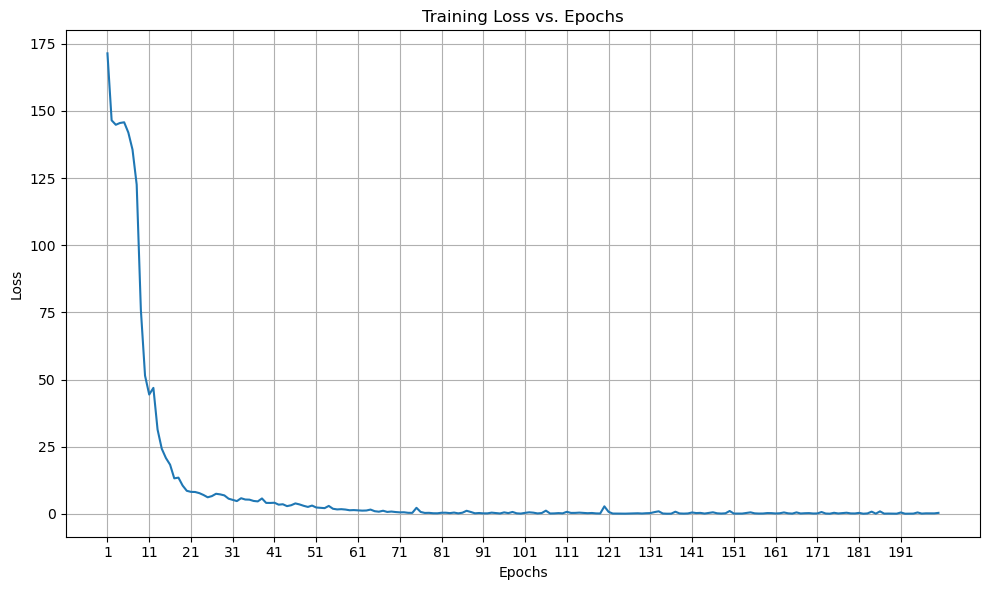

In [38]:
final_model, train_loader, test_loader, device, train_losses = train_autoencoder(
    df,
    epochs=200,  # Train longer with the best params
    batch_size=32,
    learning_rate=0.00109128955824676,
    encoding_dim=32,
    weight_decay=1.8049789124923568e-05
)

plot_loss(train_losses)

In [39]:
# Test the model
metrics = test_autoencoder(final_model, train_loader, test_loader, device)

print(f"Final Train MAE: {metrics['train_mae']:.4f}, Train R²: {metrics['train_r2']:.4f}")
print(f"Final Test MAE: {metrics['test_mae']:.4f}, Test R²: {metrics['test_r2']:.4f}")

Final Train MAE: 0.1630, Train R²: 0.9996
Final Test MAE: 0.1649, Test R²: 0.9996


# Graphs

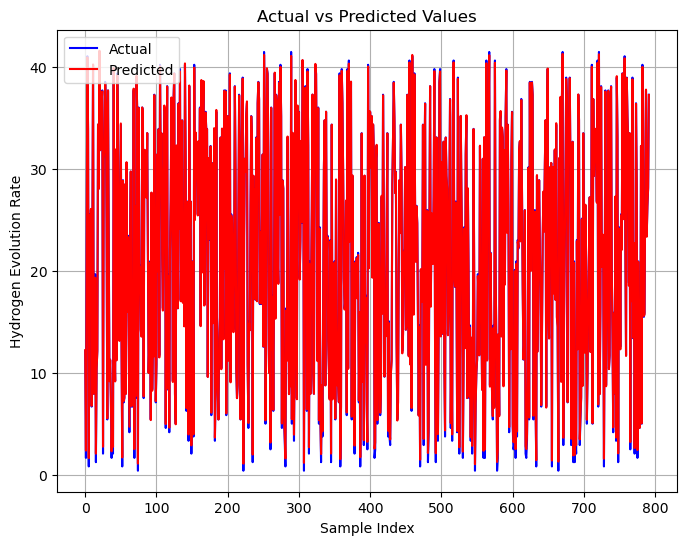

In [42]:
import matplotlib.pyplot as plt
import torch

# Get actual vs predicted values from the test set
actual_values = []
predicted_values = []

final_model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = final_model(inputs).squeeze()
        
        actual_values.extend(targets.cpu().numpy())  # Convert to NumPy
        predicted_values.extend(outputs.cpu().numpy())

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.plot(actual_values, label='Actual', color='blue')
plt.plot(predicted_values, label='Predicted',   color='red')

# Labels and title
plt.xlabel("Sample Index")
plt.ylabel("Hydrogen Evolution Rate")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


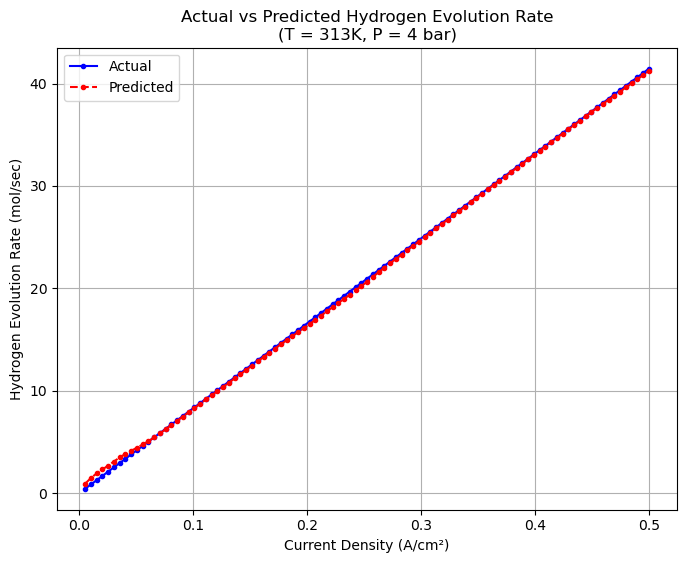

In [43]:
# Select constant temperature and pressure (e.g., T = 313K, P = 4 bar)
selected_temperature = 273 + 40  # Example: 40°C
selected_pressure = 4  # Example: 4 bar

# Filter the DataFrame
filtered_df = df[(df["Temperature"] == selected_temperature) & (df["Pressure"] == selected_pressure)]

# Sort by Current Density
filtered_df = filtered_df.sort_values(by="Current Density")

# Extract actual values
current_density_values = filtered_df["Current Density"].values
actual_hydrogen_evolution = filtered_df["Hydrogen Evolution Rate"].values

# Convert to Tensor for Model Prediction
model_inputs = torch.tensor(filtered_df[['Temperature', 'Pressure', 'Current Density',
                                         'Bubble Coverage', 'Reversible Voltage',
                                         'Activation Overpotential', 'Ohmic Potential',
                                         'Cell Voltage']].values, dtype=torch.float32).to(device)

# Predict using the trained model
final_model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predicted_hydrogen_evolution = final_model(model_inputs).cpu().numpy().squeeze()

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.plot(current_density_values, actual_hydrogen_evolution, label='Actual', marker='.', linestyle='-', color='blue')
plt.plot(current_density_values, predicted_hydrogen_evolution, label='Predicted', marker='.', linestyle='--', color='red')

# Labels and title
plt.xlabel("Current Density (A/cm²)")
plt.ylabel("Hydrogen Evolution Rate (mol/sec)")
plt.title(f"Actual vs Predicted Hydrogen Evolution Rate\n(T = {selected_temperature}K, P = {selected_pressure} bar)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [44]:
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

# Extract unique temperature and pressure values from the DataFrame
temperature_values = sorted(df["Temperature"].unique())
pressure_values = sorted(df["Pressure"].unique())

# Define function to update the plot based on user selection
def update_plot(selected_temperature, selected_pressure):
    # Filter DataFrame for selected T and P
    filtered_df = df[(df["Temperature"] == selected_temperature) & (df["Pressure"] == selected_pressure)]
    filtered_df = filtered_df.sort_values(by="Current Density")

    # Extract values
    current_density_values = filtered_df["Current Density"].values
    actual_hydrogen_evolution = filtered_df["Hydrogen Evolution Rate"].values

    # Convert inputs to tensor for model prediction
    model_inputs = torch.tensor(filtered_df[['Temperature', 'Pressure', 'Current Density',
                                             'Bubble Coverage', 'Reversible Voltage',
                                             'Activation Overpotential', 'Ohmic Potential',
                                             'Cell Voltage']].values, dtype=torch.float32).to(device)

    # Predict using the trained model
    final_model.eval()
    with torch.no_grad():
        predicted_hydrogen_evolution = final_model(model_inputs).cpu().numpy().squeeze()

    # Create interactive plot
    fig = go.Figure()

    # Add actual values
    fig.add_trace(go.Scatter(
        x=current_density_values, y=actual_hydrogen_evolution,
        mode='lines+markers', name='Actual', line=dict(color='blue')
    ))

    # Add predicted values
    fig.add_trace(go.Scatter(
        x=current_density_values, y=predicted_hydrogen_evolution,
        mode='lines+markers', name='Predicted', line=dict(color='red', dash='dash')
    ))

    # Layout settings
    fig.update_layout(
        title=f"Actual vs Predicted Hydrogen Evolution Rate<br>(T = {selected_temperature}K, P = {selected_pressure} bar)",
        xaxis_title="Current Density (A/cm²)",
        yaxis_title="Hydrogen Evolution Rate (mol/sec)",
        legend_title="Legend",
        template="plotly_white"
    )

    # Show plot
    fig.show()

# Create interactive dropdowns
temperature_dropdown = widgets.Dropdown(
    options=temperature_values, value=temperature_values[0], description="Temperature (K)"
)
pressure_dropdown = widgets.Dropdown(
    options=pressure_values, value=pressure_values[0], description="Pressure (bar)"
)

# Define interactive output
interactive_output = widgets.interactive_output(update_plot, {
    "selected_temperature": temperature_dropdown,
    "selected_pressure": pressure_dropdown
})

# Display widgets and interactive plot
display(widgets.HBox([temperature_dropdown, pressure_dropdown]), interactive_output)


Output()

In [45]:
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
import torch

# Extract unique temperature and pressure values from the DataFrame
temperature_values = sorted(df["Temperature"].unique())
pressure_values = sorted(df["Pressure"].unique())

# Define function to update the plot based on user selection
def update_plot(selected_temperature, selected_pressure):
    # Filter DataFrame for selected T and P
    filtered_df = df[(df["Temperature"] == selected_temperature) & (df["Pressure"] == selected_pressure)]
    filtered_df = filtered_df.sort_values(by="Current Density")

    # Extract values
    current_density_values = filtered_df["Current Density"].values
    actual_hydrogen_evolution = filtered_df["Hydrogen Evolution Rate"].values

    # Convert inputs to tensor for model prediction
    model_inputs = torch.tensor(filtered_df[['Temperature', 'Pressure', 'Current Density',
                                             'Bubble Coverage', 'Reversible Voltage',
                                             'Activation Overpotential', 'Ohmic Potential',
                                             'Cell Voltage']].values, dtype=torch.float32).to(device)

    # Predict using the trained model
    final_model.eval()
    with torch.no_grad():
        predicted_hydrogen_evolution = final_model(model_inputs).cpu().numpy().squeeze()

    # Create interactive plot
    fig = go.Figure()

    # Add actual values
    fig.add_trace(go.Scatter(
        x=current_density_values, y=actual_hydrogen_evolution,
        mode='lines+markers', name='Actual', line=dict(color='blue')
    ))

    # Add predicted values
    fig.add_trace(go.Scatter(
        x=current_density_values, y=predicted_hydrogen_evolution,
        mode='lines+markers', name='Predicted', line=dict(color='red', dash='dash')
    ))

    # Layout settings
    fig.update_layout(
        title=f"Actual vs Predicted Hydrogen Evolution Rate<br>(T = {selected_temperature}K, P = {selected_pressure} bar)",
        xaxis_title="Current Density (A/cm²)",
        yaxis_title="Hydrogen Evolution Rate (mol/sec)",
        legend_title="Legend",
        template="plotly_white"
    )

    # Show plot
    fig.show()

# Create interactive dropdowns
temperature_dropdown = widgets.Dropdown(
    options=temperature_values, value=temperature_values[0], description="Temperature (K)"
)
pressure_dropdown = widgets.Dropdown(
    options=pressure_values, value=pressure_values[0], description="Pressure (bar)"
)

# Define interactive output
interactive_output = widgets.interactive_output(update_plot, {
    "selected_temperature": temperature_dropdown,
    "selected_pressure": pressure_dropdown
})

# Display widgets and interactive plot
display(widgets.HBox([temperature_dropdown, pressure_dropdown]), interactive_output)


Output()

# Model Interpretability

## Latent Space Analysis

In [47]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

# Extract latent space representations
def extract_latent_space(model, data_loader, device):
    model.eval()
    latent_data = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            encoded = model.encoder(inputs).cpu().numpy()
            latent_data.append(encoded)
    return np.vstack(latent_data)

# Visualize latent space (2D or 3D)
def visualize_latent_space(latent_data, target_values=None, title="Latent Space Visualization"):
    encoding_dim = latent_data.shape[1]
    
    if encoding_dim == 2:  # 2D scatter plot
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(latent_data[:, 0], latent_data[:, 1], c=target_values, cmap='viridis', alpha=0.7)
        if target_values is not None:
            plt.colorbar(scatter, label="Target Value")
        plt.xlabel("Latent Dimension 1")
        plt.ylabel("Latent Dimension 2")
        plt.title(title)
        plt.show()
    
    elif encoding_dim == 3:  # 3D scatter plot
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(latent_data[:, 0], latent_data[:, 1], latent_data[:, 2], c=target_values, cmap='viridis', alpha=0.7)
        if target_values is not None:
            fig.colorbar(scatter, ax=ax, label="Target Value")
        ax.set_xlabel("Latent Dimension 1")
        ax.set_ylabel("Latent Dimension 2")
        ax.set_zlabel("Latent Dimension 3")
        ax.set_title(title)
        plt.show()
    
    else:  # Use dimensionality reduction for visualization
        print(f"Reducing {encoding_dim}-dimensional latent space to 2D for visualization...")
        
        # PCA for dimensionality reduction
        pca = PCA(n_components=2)
        reduced_data_pca = pca.fit_transform(latent_data)
        
        # t-SNE for non-linear dimensionality reduction
        tsne = TSNE(n_components=2, perplexity=30, max_iter=300)
        reduced_data_tsne = tsne.fit_transform(latent_data)
        
        # Plot PCA results
        plt.figure(figsize=(8, 6))
        scatter_pca = plt.scatter(reduced_data_pca[:, 0], reduced_data_pca[:, 1], c=target_values, cmap='viridis', alpha=0.7)
        if target_values is not None:
            plt.colorbar(scatter_pca, label="Target Value")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.title("PCA Visualization of Latent Space")
        plt.show()
        
        # Plot t-SNE results
        plt.figure(figsize=(8, 6))
        scatter_tsne = plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=target_values, cmap='viridis', alpha=0.7)
        if target_values is not None:
            plt.colorbar(scatter_tsne, label="Target Value")
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.title("t-SNE Visualization of Latent Space")
        plt.show()

# Analyze clusters in latent space
def analyze_clusters(latent_data):
    # Apply k-means clustering to identify clusters in the latent space
    kmeans = KMeans(n_clusters=3)  # Adjust number of clusters as needed
    cluster_labels = kmeans.fit_predict(latent_data)
    
    # Calculate silhouette score to evaluate clustering quality
    silhouette_avg = silhouette_score(latent_data, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg:.4f}")
    
    # Visualize clusters (assuming latent space is reduced to 2D or visualizable form)
    sns.scatterplot(x=latent_data[:, 0], y=latent_data[:, 1], hue=cluster_labels, palette="deep", alpha=0.7)
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title(f"Clusters in Latent Space (Silhouette Score: {silhouette_avg:.4f})")
    plt.legend(title="Cluster Label", loc="best")
    plt.show()

# Correlation with "Hydrogen Evolution Rate"
def analyze_correlation_with_target(latent_data, target_values):
    correlations = np.corrcoef(latent_data.T, target_values)[-1][:-1]
    print(f"Correlation of each latent dimension with target variable:")
    for i, corr in enumerate(correlations):
        print(f"Dimension {i + 1}: {corr:.4f}")

# Main workflow
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extract features and targets from DataFrame `df`
features = df[['Temperature', 'Pressure', 'Current Density', 'Bubble Coverage',
               'Reversible Voltage', 'Activation Overpotential', 'Ohmic Potential',
               'Cell Voltage']].values
targets = df['Hydrogen Evolution Rate'].values

# Create DataLoader for inference
dataset = BubbleCoverageDataset(features, targets)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

Reducing 32-dimensional latent space to 2D for visualization...


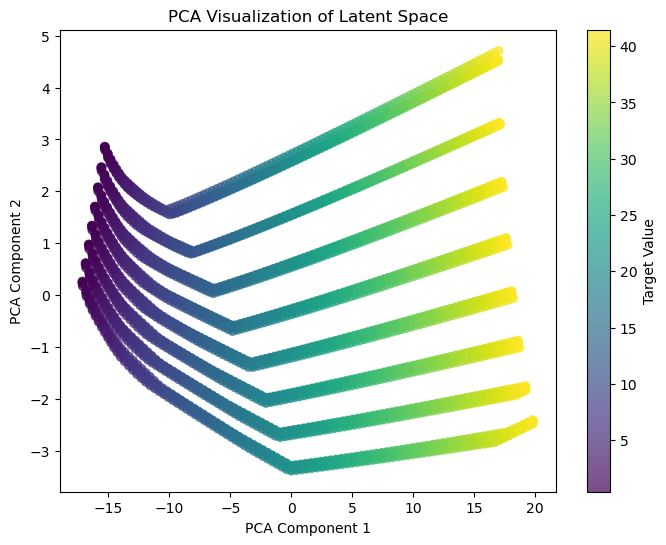

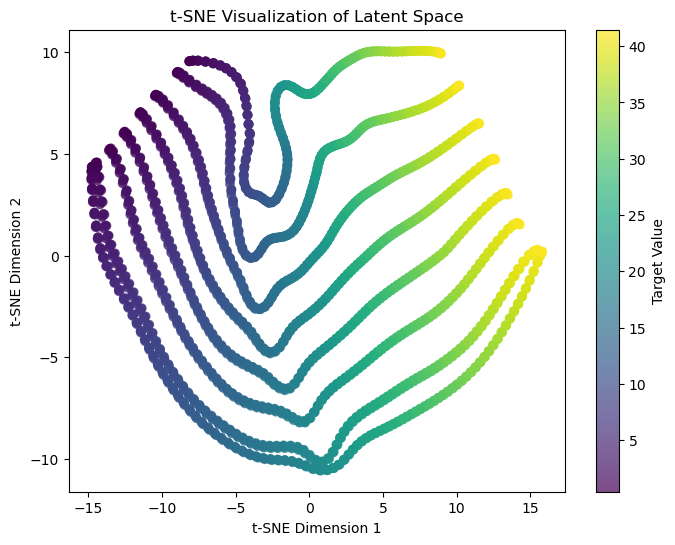

In [48]:
# Extract latent representations using the trained model
latent_space_representation = extract_latent_space(final_model, data_loader, device)

# Visualize the latent space representation
visualize_latent_space(latent_space_representation, target_values=df["Hydrogen Evolution Rate"].values)

### __Inference:__
#### PCA Visualization

 - Linear Structure: The latent space appears to have a structured, almost layered formation, suggesting that the data has a strong linear correlation.

 - Smooth Gradients: The transition from low to high target values is smooth, which indicates that PCA retains the global structure of the data well.

 - Compression in Some Areas: PCA is a linear dimensionality reduction method, meaning it may not capture complex non-linear variations in the data.

#### t-SNE Visualization
 - Non-Linear Patterns: Unlike PCA, t-SNE captures non-linear structures and reveals curved or branched patterns.
   
 - Local Clustering: Points with similar target values (color-coded) are grouped more distinctly, suggesting that t-SNE effectively separates different regions of the latent space.

   
 - Distorted Global Structure: While local relationships are well preserved, global relationships (such as distances between different groups) may not be as meaningful, as t-SNE focuses on maintaining local neighborhood integrity.

Silhouette Score: 0.5311


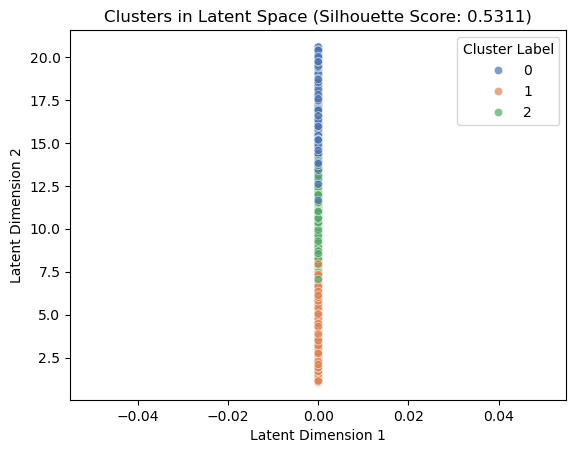

In [49]:
# Analyze clusters in the latent space representation
analyze_clusters(latent_space_representation)

### Findings from above output:
1. Linear Structure of Latent Space
    - The data follows a strong continuous pattern rather than forming distinct clusters.
    - The latent space is highly structured and nearly linear.
<br><br>
2. Cluster Formation
    - Cluster transitions are smooth, suggesting a gradual shift rather than clear separation.
<br><br>
3. Silhouette Score Interpretation (0.5576)
    - A moderate clustering quality, indicating some separation but no clear boundaries.
    - Clusters may be part of a continuous gradient rather than truly distinct groups.    

In [50]:
# Analyze correlation between each dimension of the latent space and "Hydrogen Evolution Rate"
analyze_correlation_with_target(latent_space_representation, df["Hydrogen Evolution Rate"].values)

Correlation of each latent dimension with target variable:
Dimension 1: nan
Dimension 2: 0.9779
Dimension 3: nan
Dimension 4: nan
Dimension 5: nan
Dimension 6: nan
Dimension 7: nan
Dimension 8: nan
Dimension 9: nan
Dimension 10: nan
Dimension 11: nan
Dimension 12: 0.8725
Dimension 13: nan
Dimension 14: nan
Dimension 15: nan
Dimension 16: 0.9942
Dimension 17: nan
Dimension 18: nan
Dimension 19: nan
Dimension 20: nan
Dimension 21: nan
Dimension 22: 0.9973
Dimension 23: nan
Dimension 24: 0.9704
Dimension 25: 0.9971
Dimension 26: nan
Dimension 27: nan
Dimension 28: nan
Dimension 29: nan
Dimension 30: nan
Dimension 31: nan
Dimension 32: 0.7952


C:\Users\Kinjal Mitra\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

C:\Users\Kinjal Mitra\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



## Feature Correlations

In [51]:
import lime
import lime.lime_tabular
import shap

features = df[['Temperature', 'Pressure', 'Current Density', 'Reversible Voltage',
               'Activation Overpotential', 'Ohmic Potential', 'Cell Voltage','Bubble Coverage']]
targets = df['Hydrogen Evolution Rate']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Convert to tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

In [57]:
# LIME explanation
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=features.columns, mode="regression")
idx = np.random.randint(0, X_test.shape[0]) #Datapoint for explanation

'''
# Example: First observation where Temperature is above 300K and Pressure is 5 bar
idx = X_test[(X_test['Temperature'] > 300) & (X_test['Pressure'] == 5)].index[0]
'''

exp = explainer.explain_instance(X_test.iloc[idx].values, lambda x: final_model(torch.tensor(x, dtype=torch.float32).to(device)).cpu().detach().numpy(), num_features=8)
exp.show_in_notebook()

In [58]:
exp.save_to_file("lime_explanation.html")

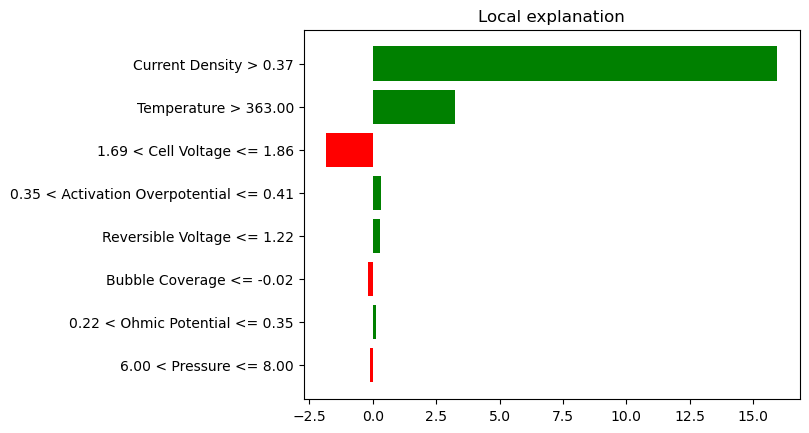

In [59]:
fig = exp.as_pyplot_figure()
plt.show()

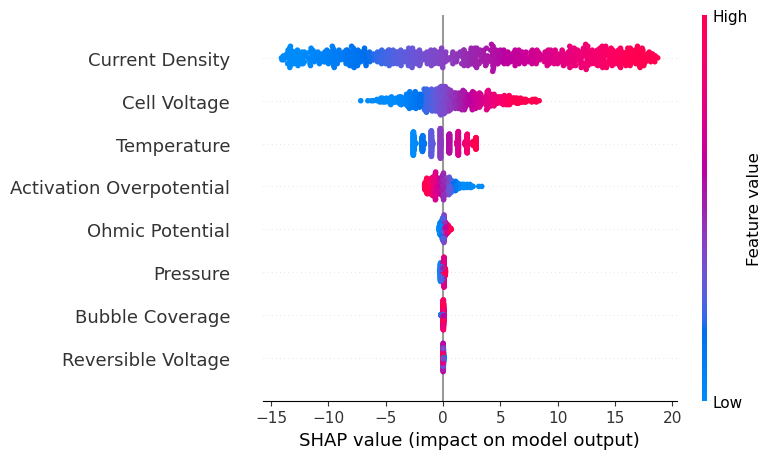

In [75]:
# SHAP explanation
explainer_shap = shap.Explainer(lambda x: final_model(torch.tensor(x, dtype=torch.float32).to(device)).cpu().detach().numpy(), X_train.values)

shap_values = explainer_shap(X_test.values)

# Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=features.columns)


Data-point index:  599


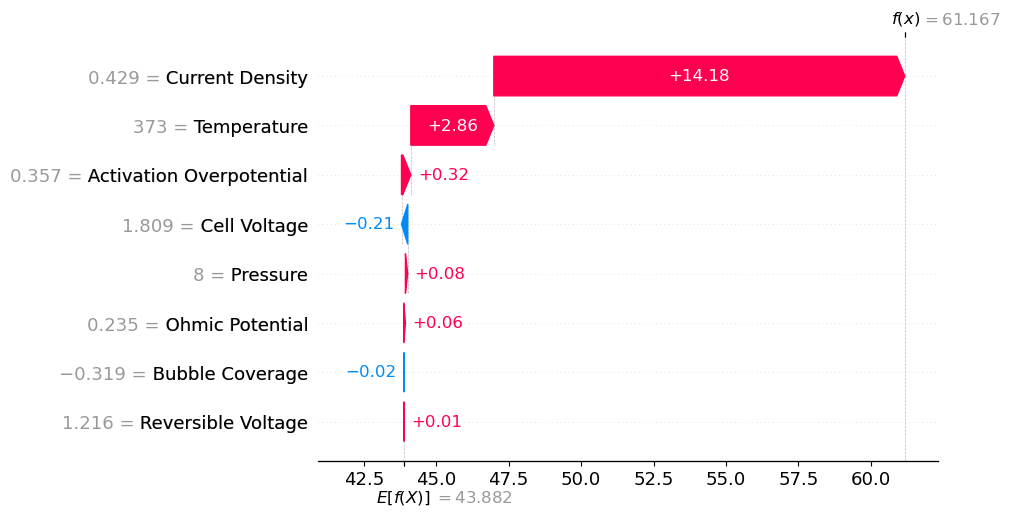

In [80]:
# Shap for individual explanation of data-points.
print("Data-point index: ",idx)
explainer_shap = shap.Explainer(
    lambda x: final_model(torch.tensor(x.values, dtype=torch.float32).to(device)).cpu().detach().numpy(), 
    X_train 
)
shap_values = explainer_shap(X_test)
shap.plots.waterfall(shap_values[idx])

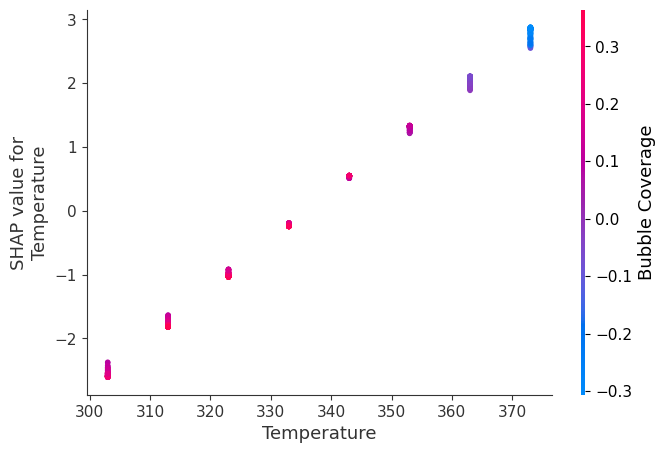

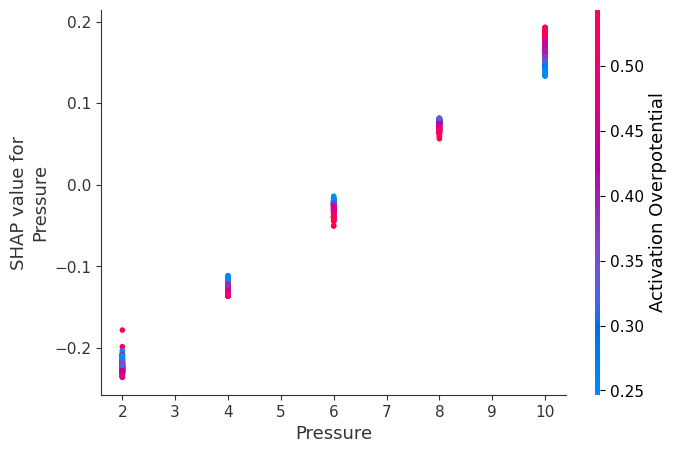

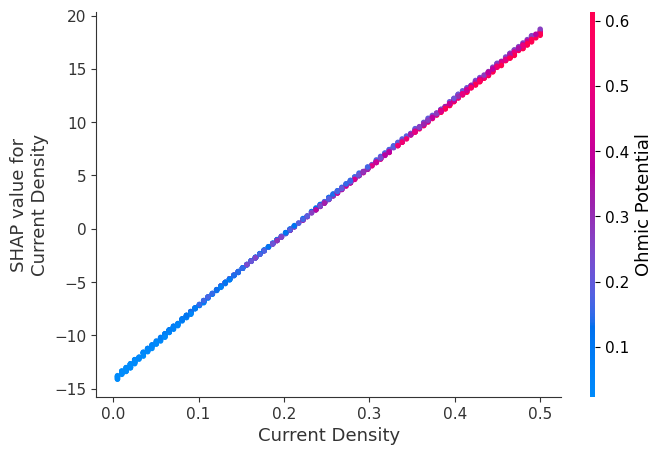

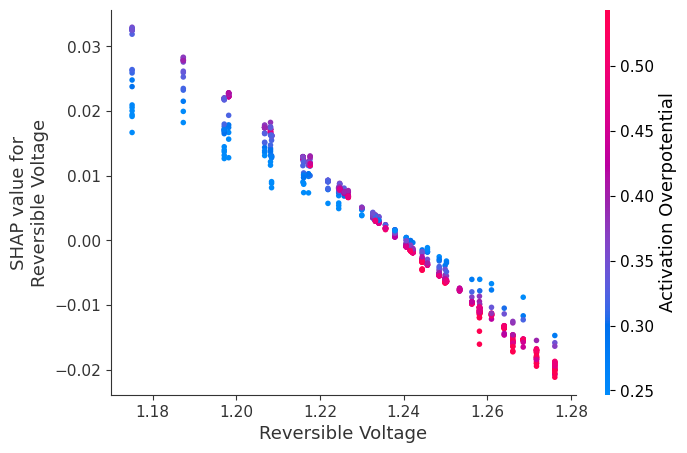

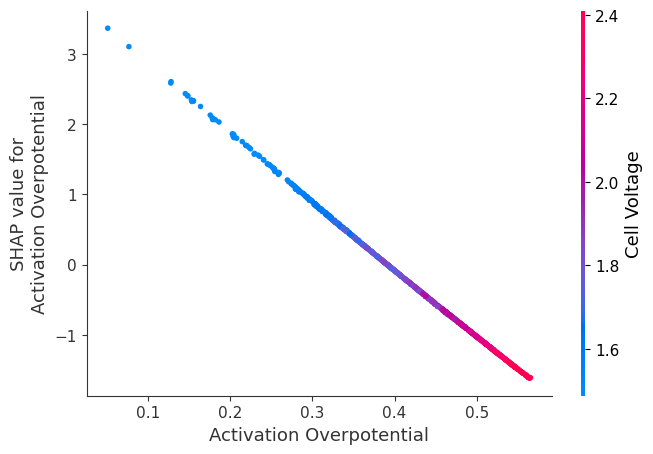

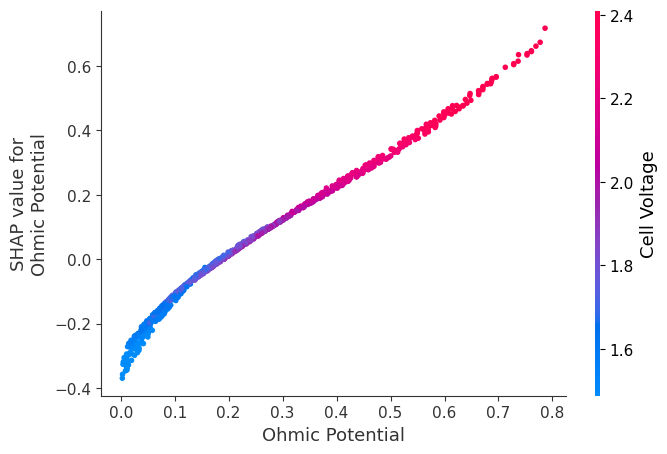

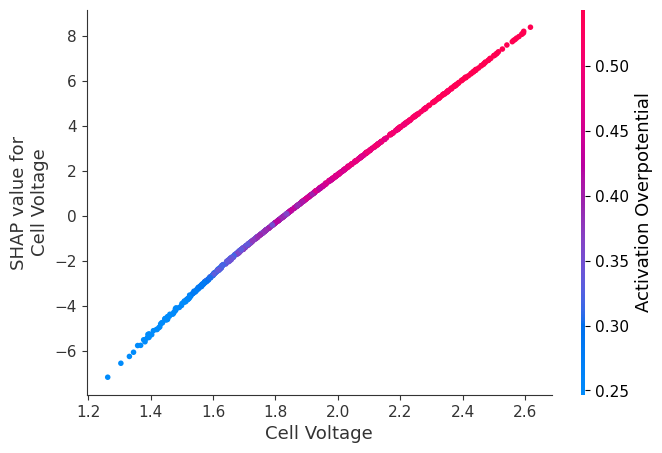

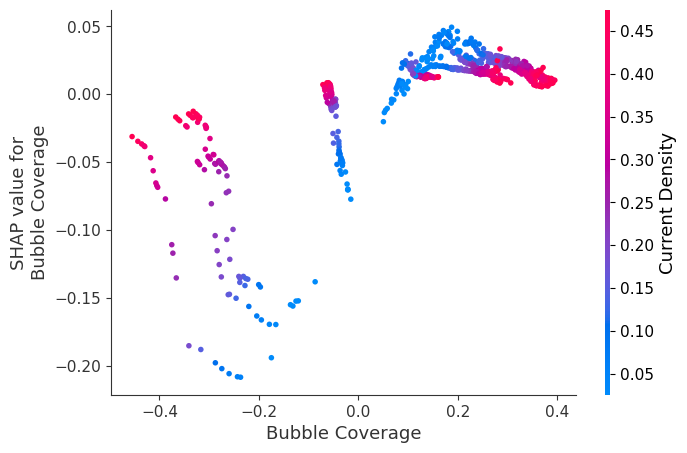

Feature importance analysis completed!


In [56]:
# Dependence Plots
for feature in features.columns:
    shap.dependence_plot(feature, shap_values.values, X_test)

print("Feature importance analysis completed!")